In [1]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import warnings
from textwrap import wrap
from mpl_toolkits import mplot3d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from re import split
from matplotlib.animation import ArtistAnimation
from scipy.ndimage import label
from scipy.ndimage.morphology import binary_closing
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
from ipywidgets import interact


warnings.filterwarnings('ignore')
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import time_3d, get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
plt.rcParams['animation.html'] = 'jshtml'
%matplotlib inline

In [2]:
# from dask_jobqueue import SLURMCluster
# import os
# from dask.distributed import Client, progress


In [4]:
# cluster = SLURMCluster(scheduler_options={'host': '172.22.179.3:7220','dashboard_address': ':7330'})


In [5]:
# client = Client(cluster)
# cluster.scale(10)

In [6]:
# client

In [7]:
# def do_something(x):
#     for i in range(10000):
#         x=x+1
#     return(x)

In [8]:
ds_xr = xr.open_zarr(f'{path_data}/zarr/KUsKAs_Wn/lores.zarr', chunks={'time':10})
df_xr = pd.DataFrame(data=ds_xr.time.values, columns=['date'])
df_times = pd.read_csv(f"{get_pars_from_ini(campaign='loc')[location]['path_proj']}/src/events.txt", 
                       header=None, parse_dates=[0], names=['date'])
merged = pd.merge(df_times, df_xr, on='date',how='left')


In [9]:
def lee_filter(img, size, tresh=-150):
    img = np.where(np.logical_or(np.isnan(img), np.equal(img, -np.inf)),  tresh, img)
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def find_events(ds_xr, height=500):
    zhh14 = ds_xr.zhh14.where(case.alt3d > height)
    filtered = lee_filter(zhh14.values, size=3, tresh=-100)    
    blurred = gaussian(filtered, sigma=.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    props = measure.regionprops(labels)
    area = [i.area for i in props]
    if any(y > 50 for y in area):
        return ds_xr.time.values
    

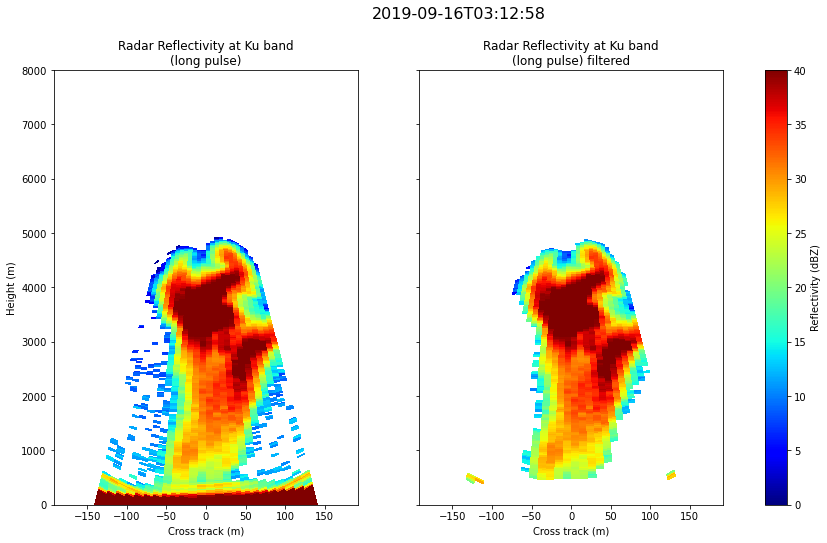

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
artist = []
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_dates = ds_xr.sel(time=slice('2019-09-16 03:12:40', '2019-09-16 03:13:40'))

for i in ds_dates.time[9:10]:
    case = ds_xr.sel(time=i)
    height = 500
    zhh14 = case.zhh14.where(case.alt3d > height)
    filtered = lee_filter(zhh14.values, size=3, tresh=-100)
    x = case.range * np.sin(np.deg2rad(case.azimuth))
    y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
    im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
    ax1.set_ylabel('Height (m)')
    ax1.set_xlabel('Cross track (m)')
    ax1.set_title("\n".join(wrap(case.zhh14.notes, 30)))
    _filtered = np.where(filtered > 0, zhh14.values, np.nan)
    im2 = ax2.pcolormesh(x, y, _filtered, 
                         cmap='jet',  vmin=0, vmax=40)
    ax2.set_xlabel('Cross track (m)')
    ax2.set_title("\n".join(wrap(case.zhh14.notes, 30)) + ' filtered')
    plt.colorbar(im1, ax=[ax1, ax2], orientation="vertical", pad=0.05, label=f'Reflectivity ({case.zhh14.units})')
    title = f"{np.datetime_as_string(case.time.values, unit='s')}\n"
    fig.suptitle(title, fontsize=16, y=.99)
    ax1.set_ylim(0, 8000)



interactive(children=(Dropdown(description='_time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

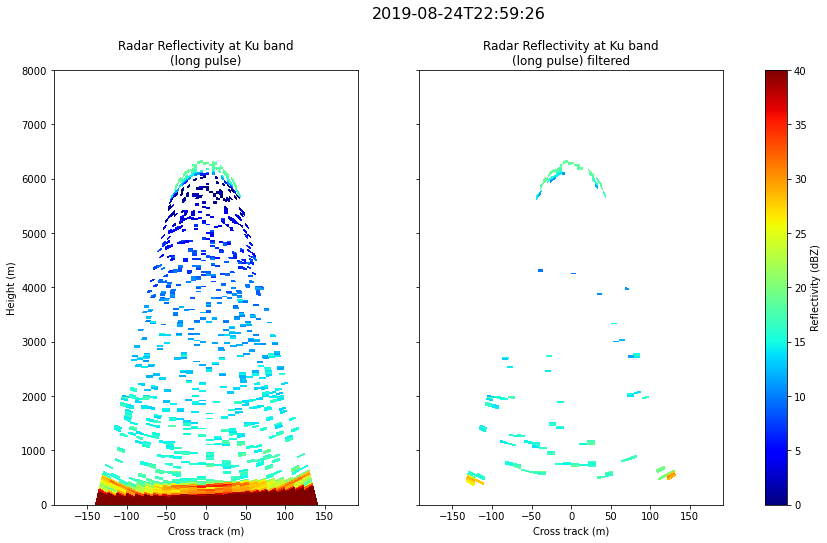

In [11]:

@interact(_time=(range(50)))
def f(_time):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
    case = ds_xr.sel(time=ds_xr.time[_time])
    height = 500
    zhh14 = case.zhh14.where(case.alt3d > height)
    filtered = lee_filter(zhh14.values, size=3, tresh=-100)
    x = case.range * np.sin(np.deg2rad(case.azimuth))
    y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
    im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
    ax1.set_ylabel('Height (m)')
    ax1.set_xlabel('Cross track (m)')
    ax1.set_title("\n".join(wrap(case.zhh14.notes, 30)))
    _filtered = np.where(filtered > 0, zhh14.values, np.nan)
    im2 = ax2.pcolormesh(x, y, _filtered, 
                         cmap='jet',  vmin=0, vmax=40)
    ax2.set_xlabel('Cross track (m)')
    ax2.set_title("\n".join(wrap(case.zhh14.notes, 30)) + ' filtered')
    plt.colorbar(im1, ax=[ax1, ax2], orientation="vertical", pad=0.05, label=f'Reflectivity ({case.zhh14.units})')
    title = f"{np.datetime_as_string(case.time.values, unit='s')}\n"
    fig.suptitle(title, fontsize=16, y=.99)
    ax1.set_ylim(0, 8000)


In [12]:
img = lee_filter(zhh14.values, 3, -100)
original = np.where(np.logical_or(np.isnan(img), np.equal(img, -np.inf)),  -100, img)

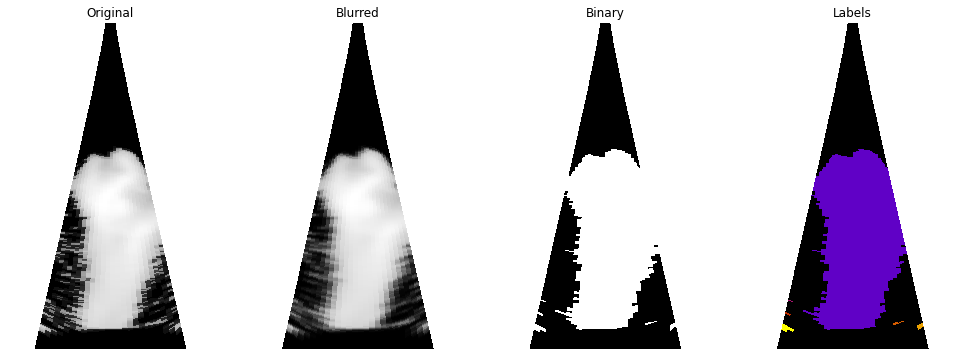

Label: 1 >> Object area (number of pixels): 2653
Label: 2 >> Object area (number of pixels): 1
Label: 3 >> Object area (number of pixels): 1
Label: 4 >> Object area (number of pixels): 2
Label: 5 >> Object area (number of pixels): 3
Label: 6 >> Object area (number of pixels): 12
Label: 7 >> Object area (number of pixels): 9


In [13]:
blurred = gaussian(original, sigma=.8)
binary = blurred > threshold_otsu(blurred)
labels = measure.label(binary)

plots = {'Original': original, 'Blurred': blurred, 
         'Binary': binary, 'Labels': labels}
fig, ax = plt.subplots(1, len(plots), figsize=(17, 6))

x = case.range * np.sin(np.deg2rad(case.azimuth))
y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
for n, (title, img) in enumerate(plots.items()):
    cmap = plt.cm.gnuplot if n == len(plots) - 1 else plt.cm.gray
    ax[n].pcolormesh(x, y, img, cmap=cmap)
    ax[n].axis('off')
    ax[n].set_title(title)
    ax[n].set_ylim(0, 8000)
plt.show(fig)

props = measure.regionprops(labels)
for prop in props:
    print('Label: {} >> Object area (number of pixels): {}'.format(prop.label, prop.area))

In [14]:
def _find_events(ds_xr):
    height=500
    %%debug 
    zhh14 = ds_xr.zhh14.where(case.alt3d > height)
    filtered = lee_filter(zhh14.values, size=3, tresh=-100)    
    blurred = gaussian(filtered, sigma=.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    props = measure.regionprops(labels)
    area = [i.area for i in props]
    if any(y > 50 for y in area):
        return ds_xr.time.values

In [15]:
ds_dates

<xarray.Dataset>
Dimensions:            (bin_size: 1, cross_track: 25, time: 33, range: 456, vector: 3)
Coordinates:
    alt3d              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
  * cross_track        (cross_track) int64 0 1 2 3 4 5 6 ... 19 20 21 22 23 24
    lat3d              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    lon3d              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
  * time               (time) datetime64[ns] 2019-09-16T03:12:41.799800 ... 2...
Dimensions without coordinates: bin_size, range, vector
Data variables: (12/58)
    DR                 (bin_size) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Xat_km             (cross_track, time) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    alt3D              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    alt_nav            (cross_track, time) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    altsurf14          (cross_track, time) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    altsurf35          (cross_track, time) float64 dask.array<chunksize=(25, 2), meta=np.ndarray>
    ...                 ...
    vel95s             (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    z95s               (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    zhh14              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    zhh14SP            (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    zhh35              (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>
    zhh35SP            (range, cross_track, time) float64 dask.array<chunksize=(114, 7, 2), meta=np.ndarray>

In [16]:
# client.close()
# cluster.close()